# Gumbel Softmax VAE

This notebook is intended for loading and exploring arbitrary pre-trained models

In [1]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)


# Settings

In [3]:
SAVE_NAME = 'gsvae'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'


TEST_SIZE = 1000
EPOCHS = 50
LR = 1e-03
BATCH_SIZE = 32

TEMPERATURE = 1


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Dataset

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: pallets_labels.json


In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Training

In [8]:
input_dim = 222 * 24 * 24
hidden_dim = 128
latent_dim = 32
classes_dim = len(dataset._label_keys)  # 92


In [9]:
model = M.gumbel.GSVAE(
    input_dim, hidden_dim, latent_dim, classes_dim, TEMPERATURE
)
criterion = M.gumbel.Loss()

train_losses, test_losses = M.gumbel.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS,
)

M.save(SAVE_NAME, model, train_losses, test_losses)


INFO | model: pallets.models.gumbel.GSVAE
INFO | criterion: pallets.models.gumbel.Loss
INFO | learn rate: 0.001
INFO | epochs: 50
INFO | epoch 1 (  0%) loss: 1418800.750000
INFO | epoch 1 ( 35%) loss: 257052.760762
INFO | epoch 1 ( 70%) loss: 134988.705958
INFO | epoch 1 (100%) loss: 99491.173621
INFO | epoch 1 (test) loss: 11285.980515
INFO | epoch 2 (  0%) loss: 11743.726562
INFO | epoch 2 ( 35%) loss: 11392.429842
INFO | epoch 2 ( 70%) loss: 11333.165778
INFO | epoch 2 (100%) loss: 11251.151843
INFO | epoch 2 (test) loss: 11126.001442
INFO | epoch 3 (  0%) loss: 11288.367188
INFO | epoch 3 ( 35%) loss: 11137.760675
INFO | epoch 3 ( 70%) loss: 11151.983680
INFO | epoch 3 (100%) loss: 11145.317053
INFO | epoch 3 (test) loss: 11070.481850
INFO | epoch 4 (  0%) loss: 10891.550781
INFO | epoch 4 ( 35%) loss: 11097.089747
INFO | epoch 4 ( 70%) loss: 11153.761568
INFO | epoch 4 (100%) loss: 11116.495903
INFO | epoch 4 (test) loss: 11043.736076
INFO | epoch 5 (  0%) loss: 10931.240234
INFO 

# Results

## Random Inputs

In [10]:
def rand_punk():
    z = torch.randn(1, latent_dim*classes_dim).to(device)
    with torch.no_grad():
        model.eval()
        generated_image = model.decoder(z)
    decoded_one_hot = generated_image[0].view(222, 24, 24)
    decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
    return decoded


### 5 Randoms

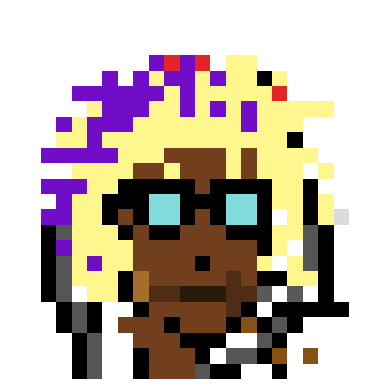

In [11]:
decoded = rand_punk()
plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


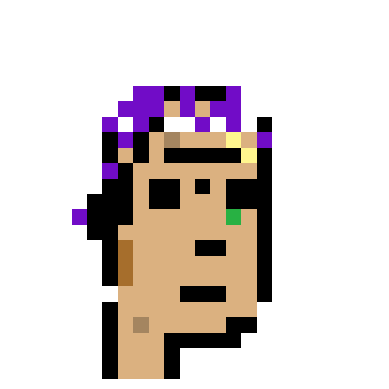

In [12]:
decoded = rand_punk()
plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


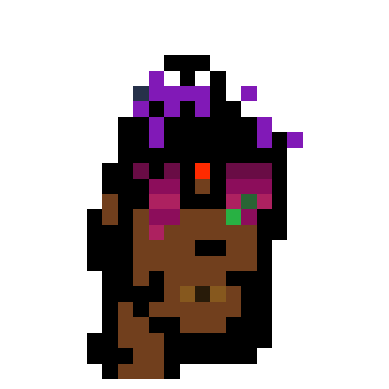

In [13]:
decoded = rand_punk()
plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


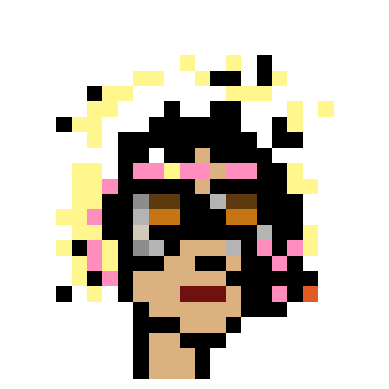

In [14]:
decoded = rand_punk()
plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


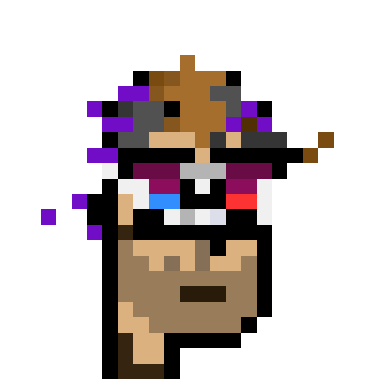

In [15]:
decoded = rand_punk()
plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


## Reconstruction

In [16]:
def reconstruct_punk(idx):
    punk = I.get_punk_tensor(idx)
    x = DS.rgba_to_one_hot(punk, dataset.mapper)
    x = x.unsqueeze(0)
    x = x.to(device)

    model.eval()
    with torch.no_grad():
        reconstructed, x_y = model.forward(x)

    recon_punk = reconstructed[0].cpu()
    recon_punk = recon_punk.view((222, 24, 24))
    recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)

    return punk, recon_punk


def draw_two(img1, img2):
    page_size = 2
    view_x, view_y = 4*page_size, 2*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(1, 2, 1)
    plt.imshow(to_pil_image(img1))
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(to_pil_image(img2))
    plt.axis('off')
    plt.show()


### 5 Reconstructions

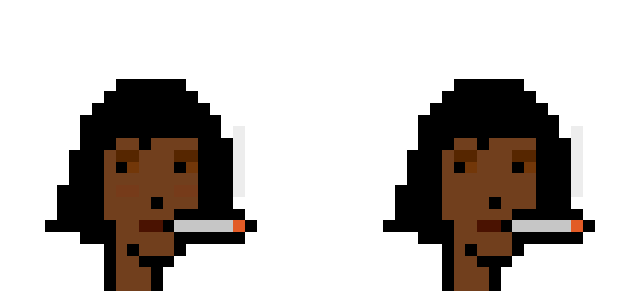

In [17]:
punk, recon_punk = reconstruct_punk(1000)

draw_two(punk, recon_punk)

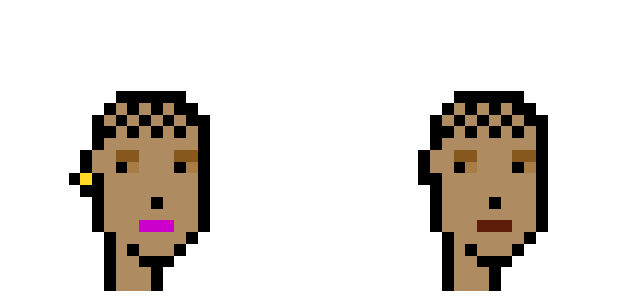

In [18]:
punk, recon_punk = reconstruct_punk(2001)

draw_two(punk, recon_punk)

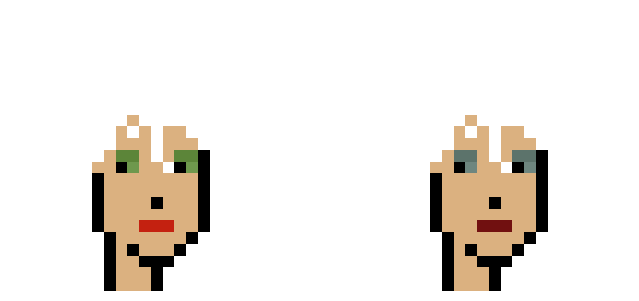

In [19]:
punk, recon_punk = reconstruct_punk(5000)

draw_two(punk, recon_punk)

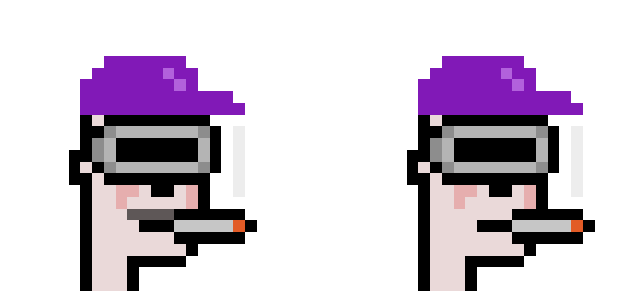

In [20]:
punk, recon_punk = reconstruct_punk(8000)

draw_two(punk, recon_punk)

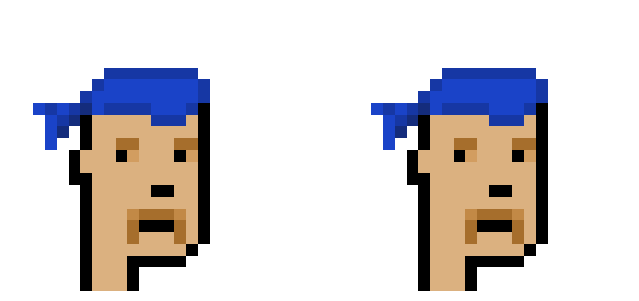

In [21]:
punk, recon_punk = reconstruct_punk(1337)

draw_two(punk, recon_punk)

## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

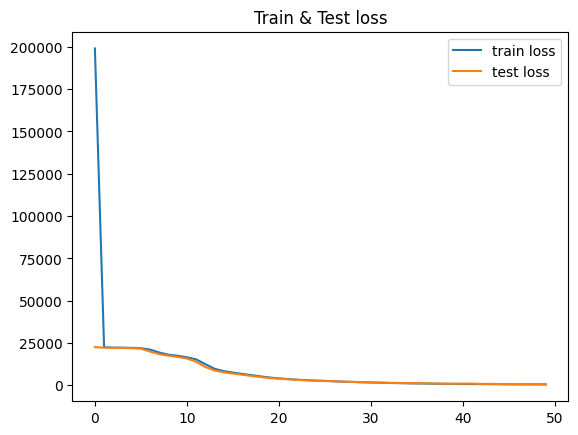

In [22]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [23]:
train_losses

[198982.34724242298,
 22502.30368669659,
 22290.634105925863,
 22232.991806571365,
 22130.401432984265,
 21938.09115795379,
 21117.198503643063,
 19359.177001953125,
 18078.997295406694,
 17453.065060013574,
 16557.40653742797,
 15346.697761697973,
 12489.694778334164,
 9806.410673100898,
 8367.866426075603,
 7525.3730953568265,
 6736.018816575936,
 6009.980866993573,
 5261.299960521941,
 4617.243730260971,
 4089.6556182212016,
 3704.0612357930936,
 3334.3176901526485,
 3042.88310057728,
 2802.4065021487836,
 2585.5575788782,
 2375.10884905876,
 2177.121596316074,
 2020.5895584863974,
 1825.4737039119639,
 1677.4083137241662,
 1546.2095938608156,
 1399.048649131829,
 1294.8519833612104,
 1185.1636935836034,
 1100.2267722271858,
 1048.219995809785,
 963.8165526153348,
 906.8631115636082,
 831.1534789065097,
 801.1672006701747,
 773.9446528549736,
 729.8693598754018,
 704.5023780985082,
 631.8088747660319,
 579.1069752578194,
 581.32907645584,
 540.8843329679881,
 554.7637678646872,
 504

In [24]:
test_losses

[22571.961029052734,
 22252.002883911133,
 22140.96369934082,
 22087.47215270996,
 21925.692581176758,
 21664.9483795166,
 19925.747772216797,
 18392.378967285156,
 17512.872848510742,
 16785.49317932129,
 15816.550979614258,
 14008.784141540527,
 10803.719032287598,
 8779.18130493164,
 7693.251667022705,
 6973.252830505371,
 6286.517688751221,
 5542.608009338379,
 4854.278553009033,
 4277.093608856201,
 3949.0183296203613,
 3545.6073150634766,
 3213.559465408325,
 2983.8041076660156,
 2705.214569091797,
 2629.09499168396,
 2413.212158203125,
 2127.26372051239,
 1999.631311416626,
 1832.3180570602417,
 1737.8406229019165,
 1606.5952453613281,
 1472.1562747955322,
 1402.6622486114502,
 1295.1608543395996,
 1248.424548149109,
 1205.676453590393,
 1072.409870147705,
 983.7386693954468,
 969.0775680541992,
 990.7875242233276,
 1016.5794057846069,
 808.6237897872925,
 868.968822479248,
 776.2360033988953,
 740.0016222000122,
 715.5396037101746,
 664.8779273033142,
 695.7825222015381,
 584.6